In [2]:
import sys
sys.path.append("../..")
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import itertools
from func.iit_tpm import make_tpm, tpm_series, dis_mean
from func.grn_tpm import text_bn_graph, iit_tpm_cal, tpm_to_dis

bnet = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('E1', 'A'): 'w1a',
    ('E1', 'B'): 'w1b',
    ('E1', 'C'): 'w1c',
    ('E2', 'A'): 'w2a',
    ('E2', 'B'): 'w2b',
    ('E2', 'C'): 'w2c',
}

In [3]:
import random
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#9B76B2', "#B99523", "#27B5AF", "#1E90FF", "#87CEEB"]

def shuffle_data(inputs, targets):
    # 生成随机索引
    indices = torch.randperm(len(inputs))
    # 根据随机索引打乱输入和目标
    shuffled_inputs = inputs[indices]
    shuffled_targets = targets[indices]
    return shuffled_inputs, shuffled_targets

def make_data2(tpm_v, samples):
    inputs = np.zeros([samples, 32])
    target = np.zeros([samples])
    def generate_random_32d_one_hot():
        index = np.random.randint(0, 32)
        one_hot = np.zeros(32)
        one_hot[index] = 1
        return one_hot
    for s in range(samples):
        sample = generate_random_32d_one_hot()
        inputs[s,:] = sample
        P = tpm_v[np.argmax(sample),:]
        target[s] = np.random.choice(range(len(P)), p=P)
    return inputs, target

def int_to_one_hot(num, size=32):
    one_hot = [0] * size
    one_hot[num] = 1
    return one_hot

def test_syn(model):
    model.eval()
    func = torch.nn.LogSoftmax(dim=1)
    tpm_trained = np.ones([32, 8])
    for i in range(32):
        inputs = torch.tensor([int_to_one_hot(i)]).float().to(device)
        tpm_trained[i,:] = np.exp(func(model(inputs)).data.numpy())

    un_sys, un_en, syn, expansive, introverted, tpm_dic = iit_tpm_cal(tpm_trained, mech_size=3, en_size=2, dis=True) 
    return syn, expansive, introverted

w = 0.5
w1 = 0.5*(1 - w)
w2 = 1.5*(1 - w)
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': w,
    'w_b': w,
    'w_c': w,
    'w1a': w1,
    'w1b': w1,
    'w1c': w1,
    'w2a': w2,
    'w2b': w2,
    'w2c': w2
}
tpm, tpm_v = make_tpm(bnet, ww, k=25)
tpm_v = tpm_to_dis(tpm_v, 3, 2)
train_input, train_target = make_data2(tpm_v, 10)
test_input, test_target = make_data2(tpm_v, 1000)
train_target

array([7., 0., 7., 7., 7., 6., 7., 7., 5., 6.])

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(32, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 16)
        self.layer4 = nn.Linear(16, 8)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5) 
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(16)

    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x) 
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer4(x)
        return x

100%|██████████| 20/20 [00:01<00:00, 13.50it/s]


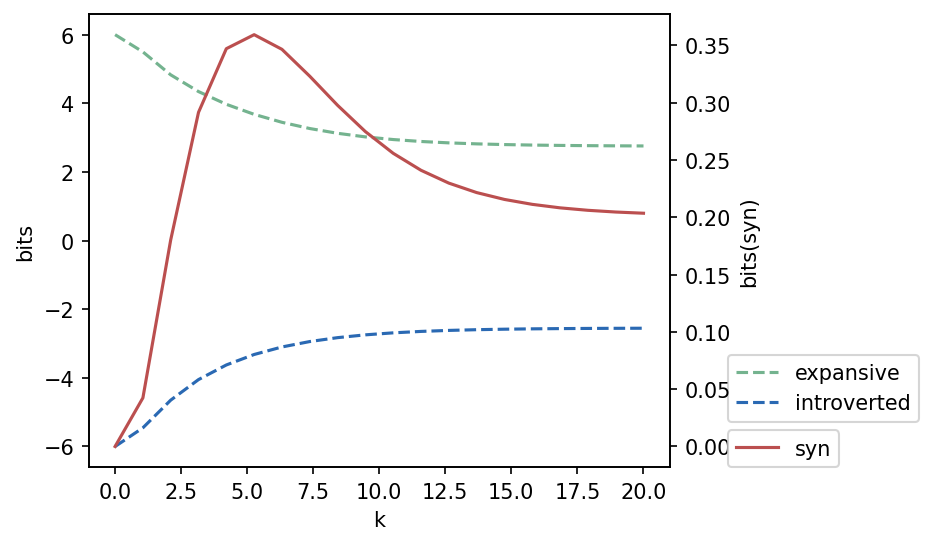

In [45]:
from tqdm import tqdm
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#9B76B2', "#B99523", "#27B5AF", "#1E90FF", "#87CEEB"]
w = 0.6
w1 = 0.5*(1 - w)
w2 = 1.5*(1 - w)
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': w,
    'w_b': w,
    'w_c': w,
    'w1a': w1,
    'w1b': w1,
    'w1c': w1,
    'w2a': w2,
    'w2b': w2,
    'w2c': w2
}

syn_list = []
expan_list = []
intro_list = []
k_axis = np.linspace(0.01, 20, 20)
for k in tqdm(k_axis):
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, expansive, introverted, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2, dis=False) 
    syn_list.append(syn)
    expan_list.append(expansive)
    intro_list.append(introverted)
    
plt.figure(figsize=(5,4),dpi=150)

# 绘制第一条线，关联到左边的 y 轴
ax1 = plt.gca()  # 获取当前坐标轴
plt.plot(k_axis, expan_list, label='expansive', linestyle="--", color=colors[2])
plt.plot(k_axis, intro_list, label="introverted", linestyle='--', color=colors[1])
plt.legend(loc=[1.1, 0.1])
# 绘制第二条线，关联到右边的 y 轴
ax2 = ax1.twinx()  # 创建与 ax1 共享 x 轴的新坐标轴
plt.plot(k_axis, syn_list, label='syn', color=colors[0])

plt.xlabel('k')

# 设置左边 y 轴的标签
ax1.set_ylabel('bits')  

# 设置右边 y 轴的标签
ax2.set_ylabel('bits(syn)')  
ax1.set_xlabel('k')
ax2.set_xlabel('k')
plt.legend(loc=[1.1, 0])
plt.show()

In [46]:
func = torch.nn.LogSoftmax(dim=1)
L = torch.nn.NLLLoss()
seeds = range(10)
interval = 5
syn_mean_list = []
expan_mean_list = []
intro_mean_list = []
syn_std_list = []
expan_std_list = []
intro_std_list = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Training on device: {device}")
k_axis = np.linspace(0, 20, 20)
batch_size = 32
num_batches = 1000
samples = num_batches * batch_size

for k in tqdm(k_axis):
    num_epochs = int(5 + k * 5)
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    tpm_dis = tpm_to_dis(tpm_v, mech_size=3, en_size=2)
    #train_losses_arr = np.zeros([len(seeds), int(num_epochs/interval)])
    syn_arr = np.zeros([len(seeds)])
    expan_arr = np.zeros([len(seeds)])
    intro_arr = np.zeros([len(seeds)])
    random.seed(0)
    np.random.seed(0)
    train_input, train_target = make_data2(tpm_dis, samples)
    for m,seed in tqdm(enumerate(seeds)):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        model = Classifier()
        syn_t, expansive_t, introverted_t = test_syn(model)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        input_data = torch.tensor(train_input, dtype=float).float()
        targets = torch.tensor(train_target).long()
        train_losses = []
        test_losses = []
        syn_ls = []
        expan_ls = []
        intro_ls = []

        for epoch in range(num_epochs):
            model.train()
            input_data, targets = shuffle_data(input_data, targets)
            for batch in range(num_batches):
                start_idx = batch * batch_size
                end_idx = start_idx + batch_size
                batch_input = input_data[start_idx:end_idx]
                batch_targets = targets[start_idx:end_idx]
                
                outputs = model(batch_input)
                y = func(outputs)
                loss = L(y, batch_targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            #if (epoch + 1) % interval == 0:
                #syn_t, expansive_t, introverted_t = test_syn(model)
#                 train_losses.append(loss.item())
#                 syn_ls.append(syn_t)
#                 expan_ls.append(expansive_t)
#                 intro_ls.append(introverted_t)
                #print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Syn: {syn_t}')
        syn_t, expansive_t, introverted_t = test_syn(model)
        #train_losses_arr[m, :] = train_losses
        syn_arr[m] = syn_t
        expan_arr[m] = expansive_t
        intro_arr[m] = introverted_t
    syn_mean_list.append(np.mean(syn_arr))
    syn_std_list.append(np.std(syn_arr))
    expan_mean_list.append(np.mean(expan_arr))
    expan_std_list.append(np.std(expan_arr))
    intro_mean_list.append(np.mean(intro_arr))
    intro_std_list.append(np.std(intro_arr))

  0%|          | 0/20 [00:00<?, ?it/s]

Training on device: cpu



0it [00:00, ?it/s]
1it [00:11, 11.37s/it]
2it [00:23, 11.65s/it]
3it [00:35, 11.65s/it]
4it [00:46, 11.64s/it]
5it [00:59, 11.77s/it]
6it [01:11, 11.95s/it]
7it [01:23, 11.97s/it]
8it [01:36, 12.28s/it]
9it [01:47, 12.00s/it]
10it [01:59, 11.92s/it]
  5%|▌         | 1/20 [02:00<38:17, 120.92s/it]
0it [00:00, ?it/s]
1it [00:23, 23.04s/it]
2it [00:46, 23.21s/it]
3it [01:09, 23.15s/it]
4it [01:32, 23.15s/it]
5it [01:55, 23.06s/it]
6it [02:20, 23.48s/it]
7it [02:45, 24.00s/it]
8it [03:09, 23.92s/it]
9it [03:32, 23.82s/it]
10it [03:55, 23.58s/it]
 10%|█         | 2/20 [05:58<46:45, 155.85s/it]
0it [00:00, ?it/s]
1it [00:35, 35.38s/it]
2it [01:11, 35.53s/it]
3it [01:47, 35.81s/it]
4it [02:25, 36.33s/it]
5it [02:59, 35.83s/it]
6it [03:36, 36.10s/it]
7it [04:12, 35.91s/it]
8it [04:49, 36.46s/it]
9it [05:24, 36.02s/it]
10it [06:01, 36.19s/it]
 15%|█▌        | 3/20 [12:01<1:01:47, 218.11s/it]
0it [00:00, ?it/s]
1it [00:50, 50.85s/it]
2it [01:38, 49.79s/it]
3it [02:27, 49.73s/it]
4it [03:16, 49.

In [47]:
# np.save("syn_mean_list.npy", syn_mean_list)
# np.save("expan_mean_list.npy", expan_mean_list)
# np.save("intro_mean_list.npy", intro_mean_list)
# np.save("syn_std_list.npy", syn_std_list)
# np.save("expan_std_list.npy", expan_std_list)
# np.save("intro_std_list.npy", intro_std_list)

np.save("syn_mean_final.npy", syn_mean_list)
np.save("expan_mean_final.npy", expan_mean_list)
np.save("intro_mean_final.npy", intro_mean_list)
np.save("syn_std_final.npy", syn_std_list)
np.save("expan_std_final.npy", expan_std_list)
np.save("intro_std_final.npy", intro_std_list)

In [5]:
import numpy as np

# 加载.npy文件
syn_mean_final = np.load("syn_mean_final.npy")
expan_mean_final = np.load("expan_mean_final.npy")
intro_mean_final = np.load("intro_mean_final.npy")
syn_std_final = np.load("syn_std_final.npy")
expan_std_final = np.load("expan_std_final.npy")
intro_std_final = np.load("intro_std_final.npy")

# 现在你可以使用这些变量来处理数据了
# 例如，打印它们
print("Syn Mean Final:", syn_mean_final)
print("Exp Mean Final:", expan_mean_final)
print("Intro Mean Final:", intro_mean_final)
print("Syn Std Final:", syn_std_final)
print("Exp Std Final:", expan_std_final)
print("Intro Std Final:", intro_std_final)

Syn Mean Final: [9.96681659e-05 2.74948605e-02 1.42629399e-01 2.70959021e-01
 3.64592825e-01 3.83391301e-01 3.55666370e-01 3.10363183e-01
 2.67827336e-01 2.45154909e-01 2.28478831e-01 2.17814156e-01
 2.09296966e-01 2.07881988e-01 2.04740463e-01 2.02371925e-01
 2.02025966e-01 2.01677063e-01 2.01117063e-01 2.01160104e-01]
Exp Mean Final: [5.99903717 5.65648945 5.03633783 4.56870392 4.16364684 3.79372684
 3.47352373 3.22797569 3.0415936  2.9375225  2.86459733 2.81716043
 2.78558103 2.77396004 2.76510047 2.75600497 2.75329129 2.75271918
 2.75061262 2.75074458]
Intro Mean Final: [-5.9989375  -5.62899459 -4.89370843 -4.2977449  -3.79905402 -3.41033554
 -3.11785736 -2.91761251 -2.77376626 -2.69236759 -2.6361185  -2.59934628
 -2.57628407 -2.56607805 -2.56036001 -2.55363305 -2.55126532 -2.55104211
 -2.54949555 -2.54958448]
Syn Std Final: [3.16751536e-05 2.46107741e-03 5.17686146e-03 5.03597342e-03
 6.67967752e-03 6.97738473e-03 6.71750568e-03 1.07314374e-02
 3.35722691e-03 6.15688795e-03 3.7136

100%|██████████| 19/19 [00:01<00:00, 14.14it/s]


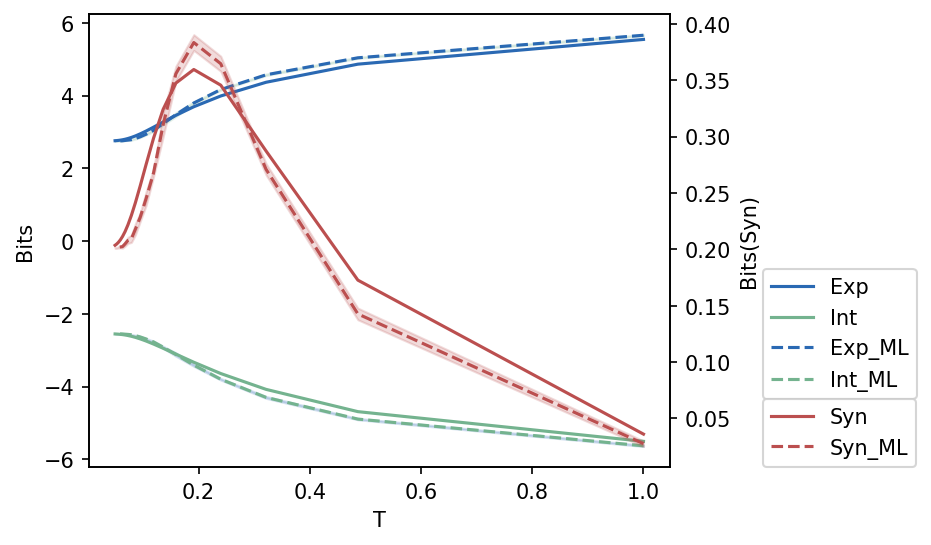

In [13]:
from tqdm import tqdm
w = 0.6
w1 = 0.5*(1 - w)
w2 = 1.5*(1 - w)
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': w,
    'w_b': w,
    'w_c': w,
    'w1a': w1,
    'w1b': w1,
    'w1c': w1,
    'w2a': w2,
    'w2b': w2,
    'w2c': w2
}

syn_list = []
expan_list = []
intro_list = []
k_axis = np.linspace(1, 20, 19)
T_axis = [1/i for i in k_axis]
#k_axis = np.linspace(0, 5, 2)
for k in tqdm(k_axis):
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, expansive, introverted, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2, dis=False) 
    syn_list.append(syn)
    expan_list.append(expansive)
    intro_list.append(introverted)
    
plt.figure(figsize=(5,4),dpi=150)

# 绘制第一条线，关联到左边的 y 轴
ax1 = plt.gca()  # 获取当前坐标轴
plt.plot(T_axis, expan_list, label='Exp', color=colors[1])
plt.plot(T_axis, intro_list, label="Int", color=colors[2])
plt.plot(T_axis, expan_mean_final[1:], label='Exp_ML', linestyle="--", color=colors[1])
plt.plot(T_axis, intro_mean_final[1:], label="Int_ML", linestyle='--', color=colors[2])
plt.fill_between(T_axis, np.array(expan_mean_final[1:])-np.array(expan_std_final[1:]), np.array(expan_mean_final[1:])+np.array(expan_std_final[1:]), alpha=0.2, color=colors[2])
plt.fill_between(T_axis, np.array(intro_mean_final[1:])-np.array(intro_std_final[1:]), np.array(intro_mean_final[1:])+np.array(intro_std_final[1:]), alpha=0.2, color=colors[1])
plt.legend(loc=[1.16, 0.15])
# 绘制第二条线，关联到右边的 y 轴
ax2 = ax1.twinx()  # 创建与 ax1 共享 x 轴的新坐标轴
plt.plot(T_axis, syn_list, label='Syn', color=colors[0])
plt.plot(T_axis, syn_mean_final[1:], label='Syn_ML', linestyle="--", color=colors[0])
plt.fill_between(T_axis, np.array(syn_mean_final[1:])-np.array(syn_std_final[1:]), np.array(syn_mean_final[1:])+np.array(syn_std_final[1:]), alpha=0.2, color=colors[0])
plt.xlabel('T')
ax1.set_ylabel('Bits')  
ax2.set_ylabel('Bits(Syn)')  
ax1.set_xlabel('T')
ax2.set_xlabel('T')
plt.legend(loc=[1.16, 0])
plt.show()